In [1]:
import os
import glob
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import product
from config import solvers, instances, rounds, chart_size, chart_dpi
from helpers import quality, effectiveness

In [24]:
NAMES = {'simulated-annealing': 'SA',
         'taboo': 'TS',
         'random-solver': 'RS',
         'heuristic-solver': 'HS',
         'local-greedy-solver': 'LG',
         'local-steepest-solver' : 'LS'}

def read_solution(instance, path):
    with open(path, 'r') as fp:
        size, cost = [int(x) for x in fp.readline().strip().split()]
        permutation = []
        
        while len(permutation) < size:
            line = fp.readline().strip().split()
            part = [int(x) for x in line]
            permutation = permutation + part
        
        return (instance, size, cost, permutation)


def get_optimal_costs():
    paths = [(instance, '../QapSolver/Data/{}.sln'.format(instance)) for instance in instances]
    solutions = [read_solution(instance, path) for instance, path in paths]
    solutions_df = pd.DataFrame(solutions, columns=['instance', 'size', 'cost', 'permutation'])
    return solutions_df
            

def get_times():
    results = []
    
    for inst, solv, rnds in product(instances, solvers, rounds):
        df_path = '../QapSolver/results/{}_{}_{}.csv'.format(inst, solv, rnds)
        df = pd.read_csv(df_path)
        
        results.append((inst, solv, df['time'].mean(), df['time'].std()))
    
    return pd.DataFrame(results, columns=['instance', 'solver', 'mean_time', 'std_time'])


def get_costs():
    results = []
    
    for inst, solv, rnds in product(instances, solvers, rounds):    
        df_path = '../QapSolver/results/{}_{}_{}.csv'.format(inst, solv, rnds)
        df = pd.read_csv(df_path)
        results.append((inst, solv, df['cost'].min(), df['cost'].mean(), df['cost'].std()))
    
    return pd.DataFrame(results, columns=['instance', 'solver', 'cost', 'mean_cost', 'std'])


def get_steps():
    results = []
    
    for inst, solv, rnds in product(instances, solvers, rounds):    
        df_path = '../QapSolver/results/{}_{}_{}.csv'.format(inst, solv, rnds)
        df = pd.read_csv(df_path)
        results.append((inst, solv, df['steps'].mean(), df['steps'].std(), df['visited'].mean(), df['visited'].std()))
    
    return pd.DataFrame(results, columns=['instance', 'solver', 'mean_steps', 'std_steps', 'mean_visited', 'std_visited'])


def get_quality(optimal_costs_df):
    results = []
    
    for inst, solv, rnds in product(instances, solvers, rounds):
        optimal_cost_row = optimal_costs_df[optimal_costs_df['instance'] == inst]
        optimal_cost = optimal_cost_row['cost'].values[0]
    
        df_path = '../QapSolver/results/{}_{}_{}.csv'.format(inst, solv, rnds)
        
        df = pd.read_csv(df_path)
        quality_series = [quality(cost, optimal_cost) for cost in df['cost'].values]
        df['quality'] = pd.Series(quality_series, index=df.index)
        
        results.append((inst, solv, df['quality'].max(), df['quality'].mean(), df['quality'].std()))
    
    return pd.DataFrame(results, columns=['instance', 'solver', 'quality', 'mean_quality', 'std'])


def get_effectiveness(optimal_costs_df, solvers=['local-greedy-solver', 'local-steepest-solver', 'taboo', 'simulated-annealing']):
    results = []
    
    
    for inst, solv, rnds in product(instances, solvers, rounds):
        optimal_cost_row = optimal_costs_df[optimal_costs_df['instance'] == inst]
        optimal_cost = optimal_cost_row['cost'].values[0]
    
        df_path = '../QapSolver/results/{}_{}_{}.csv'.format(inst, solv, rnds)
        df = pd.read_csv(df_path)
        
        quality_values = [quality(cost, optimal_cost) for cost in df['cost'].values]
        times_values = df['time'].values
        effectiveness_values = [effectiveness(q, t) for q, t in zip(quality_values, times_values)]
        df['effectiveness'] = pd.Series(effectiveness_values, index=df.index)
        
        results.append((inst, solv, df['effectiveness'].max(), df['effectiveness'].mean(), df['effectiveness'].std()))
    
    return pd.DataFrame(results, columns=['instance', 'solver', 'effectiveness', 'mean_effectiveness', 'std'])

# Jakość
4x2 Wykresy

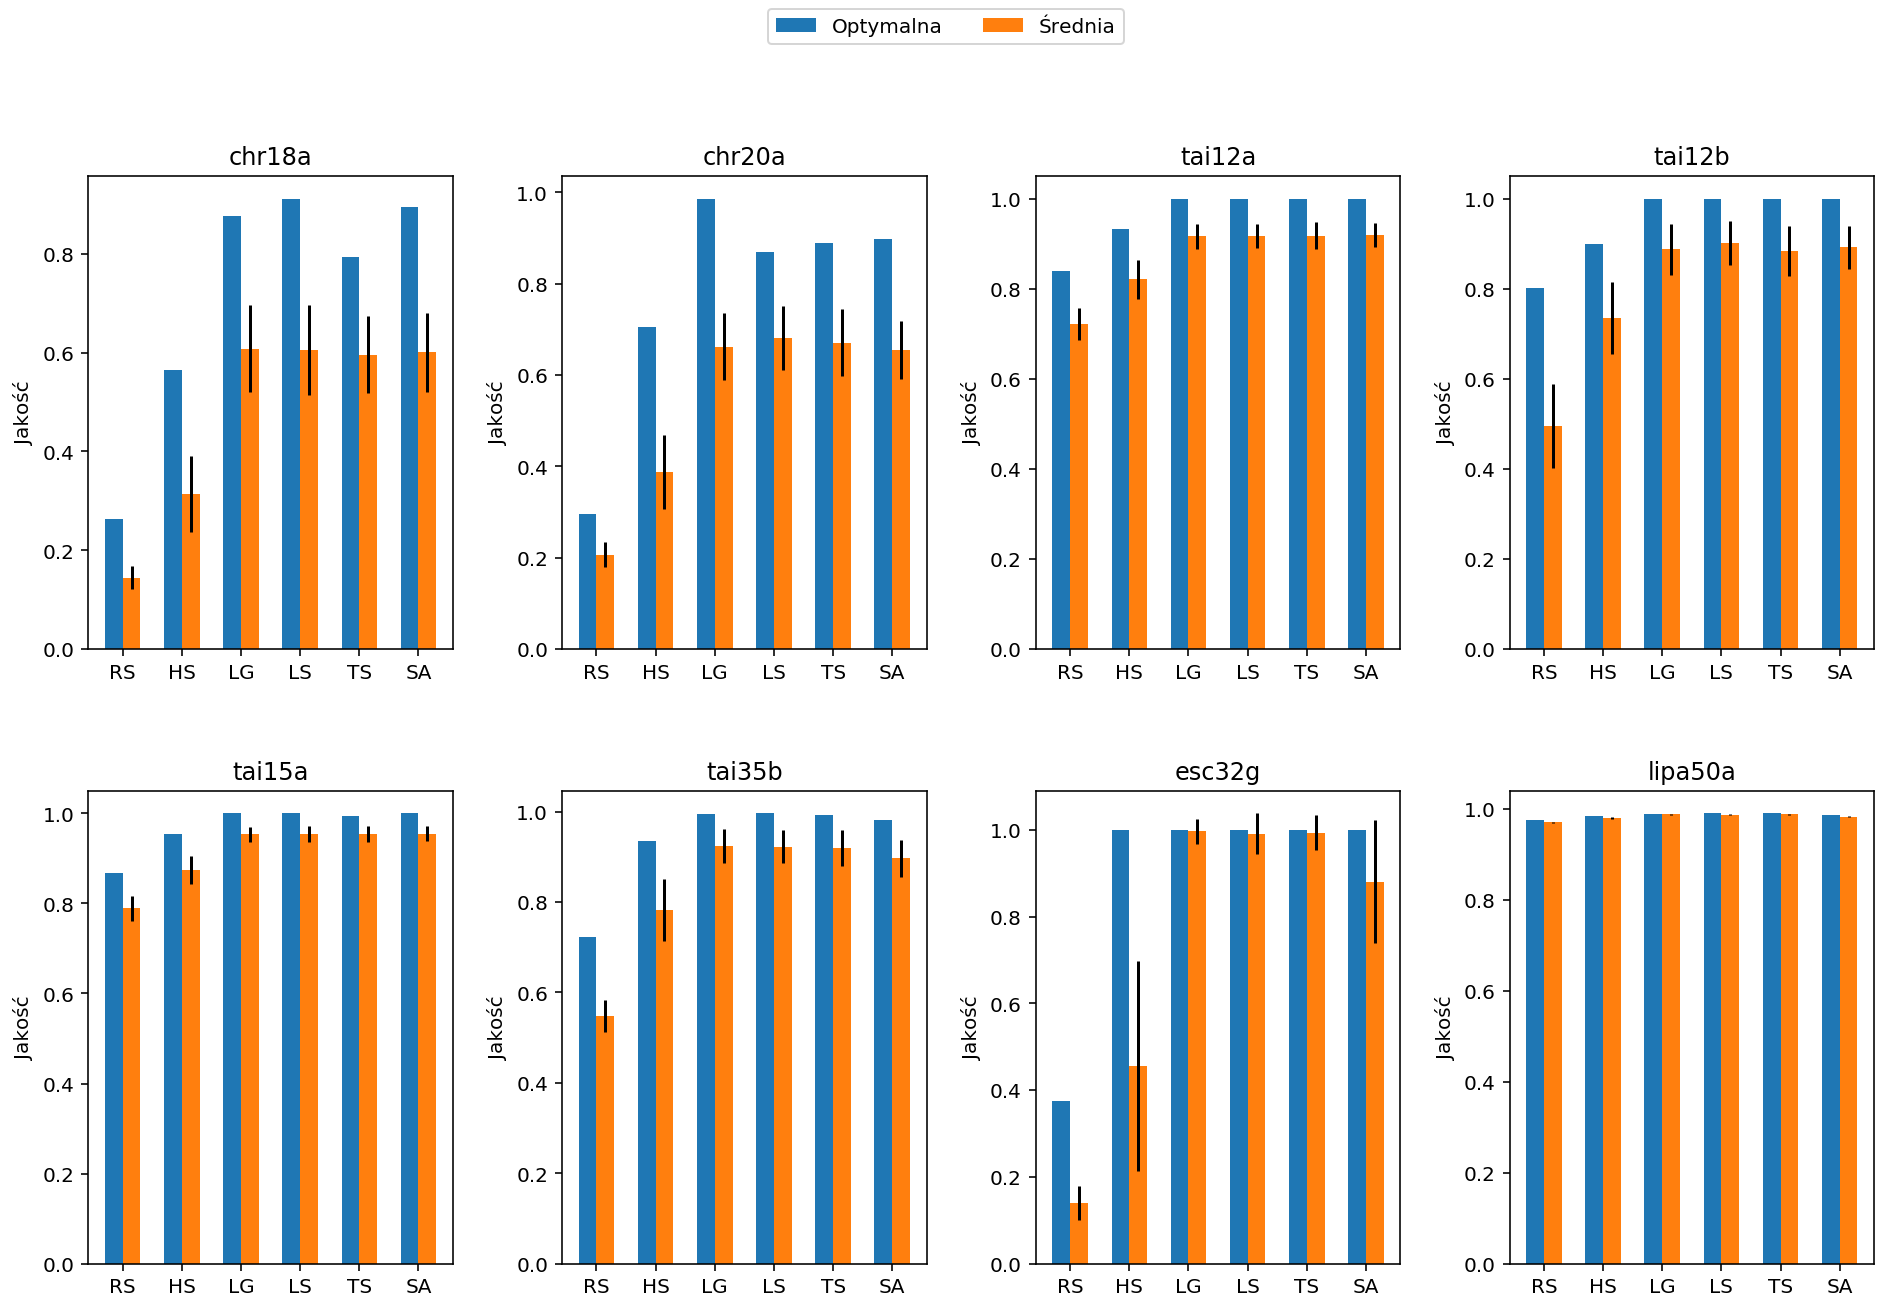

In [25]:
optimal_costs_df = get_optimal_costs()
quality_df = get_quality(optimal_costs_df)

fig, all_axes = plt.subplots(nrows=2, ncols=4, dpi=chart_dpi, figsize=chart_size)
fig.subplots_adjust(hspace=.3, wspace=.3)

for instance, ax in zip(instances, all_axes.flat):
    solvers_df = quality_df[quality_df['instance'] == instance]
    X = [NAMES[name] for name in solvers_df['solver'].values]
    Y_optimal = solvers_df['quality'].values
    Y_mean = solvers_df['mean_quality'].values
    Y_std = solvers_df['std'].values
    
    indexes = np.arange(len(X))
    bar_width = 0.30
    
    rects1 = ax.bar(indexes, Y_optimal, bar_width)
    rects2 = ax.bar(indexes + bar_width, Y_mean, bar_width, yerr=Y_std)
    
    ax.set_title(instance)
    ax.set_ylabel('Jakość')
    ax.set_xticks(indexes + bar_width / 2)
    ax.set_xticklabels(X)
    
fig.legend((rects1[0], rects2[0]), ('Optymalna', 'Średnia'), 'upper center', ncol=2)
fig.savefig('./quality.png', dpi=chart_dpi)

# Czas

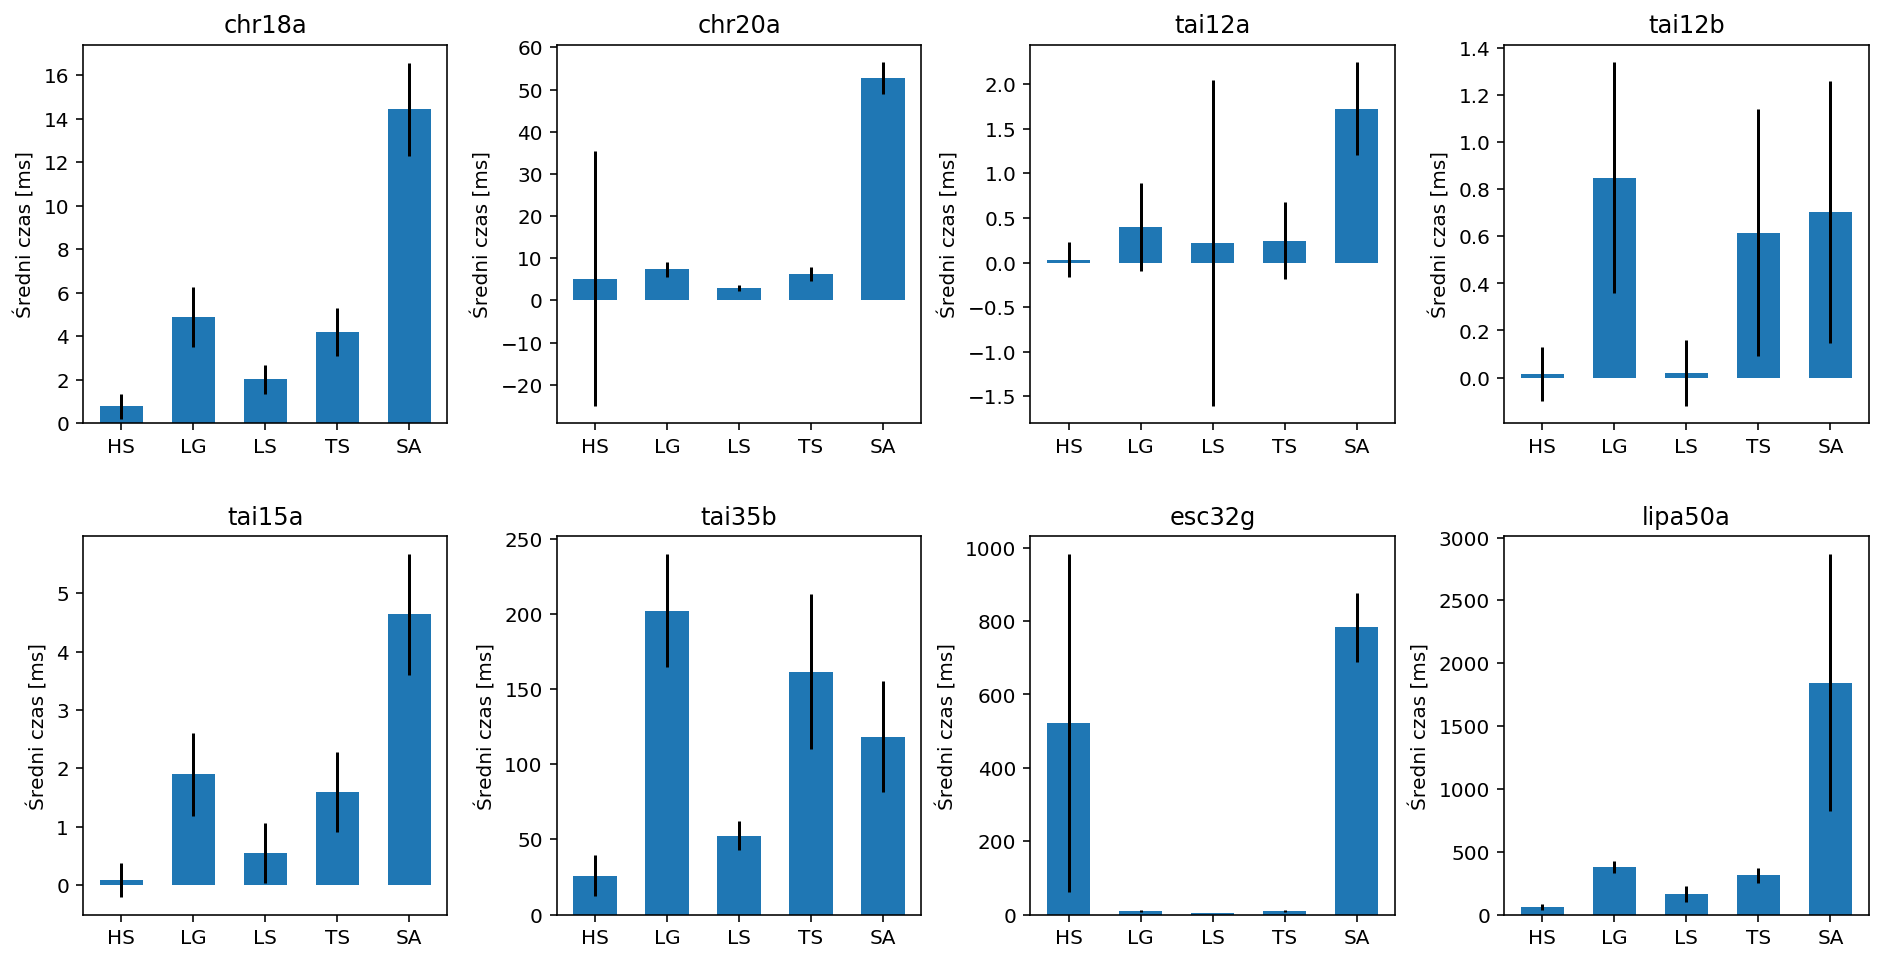

In [26]:
times_df = get_times()

fig, all_axes = plt.subplots(nrows=2, ncols=4, dpi=chart_dpi, figsize=(16, 8))
fig.subplots_adjust(hspace=.3, wspace=.3)

for instance, ax in zip(instances, all_axes.flat):
    solvers_df = times_df[times_df['instance'] == instance]
    solvers_df = solvers_df[solvers_df['solver'] != 'random-solver']
    
    X = [NAMES[name] for name in solvers_df['solver'].values]
    Y_optimal = solvers_df['mean_time'].values
    Y_std = solvers_df['std_time'].values
    
    indexes = np.arange(len(X))
    bar_width = 0.6
    
    rects1 = ax.bar(indexes, Y_optimal, bar_width, yerr=Y_std)
    
    ax.set_title(instance)
    ax.set_ylabel('Średni czas [ms]')
    ax.set_xticks(indexes)
    ax.set_xticklabels(X)

fig.savefig('./time.png', dpi=chart_dpi)

# Kroki algorytmu

`steps` - Liczba kroków algorytmu,
`visited` - Liczba ocenionych (przejrzanych) rozwiązań

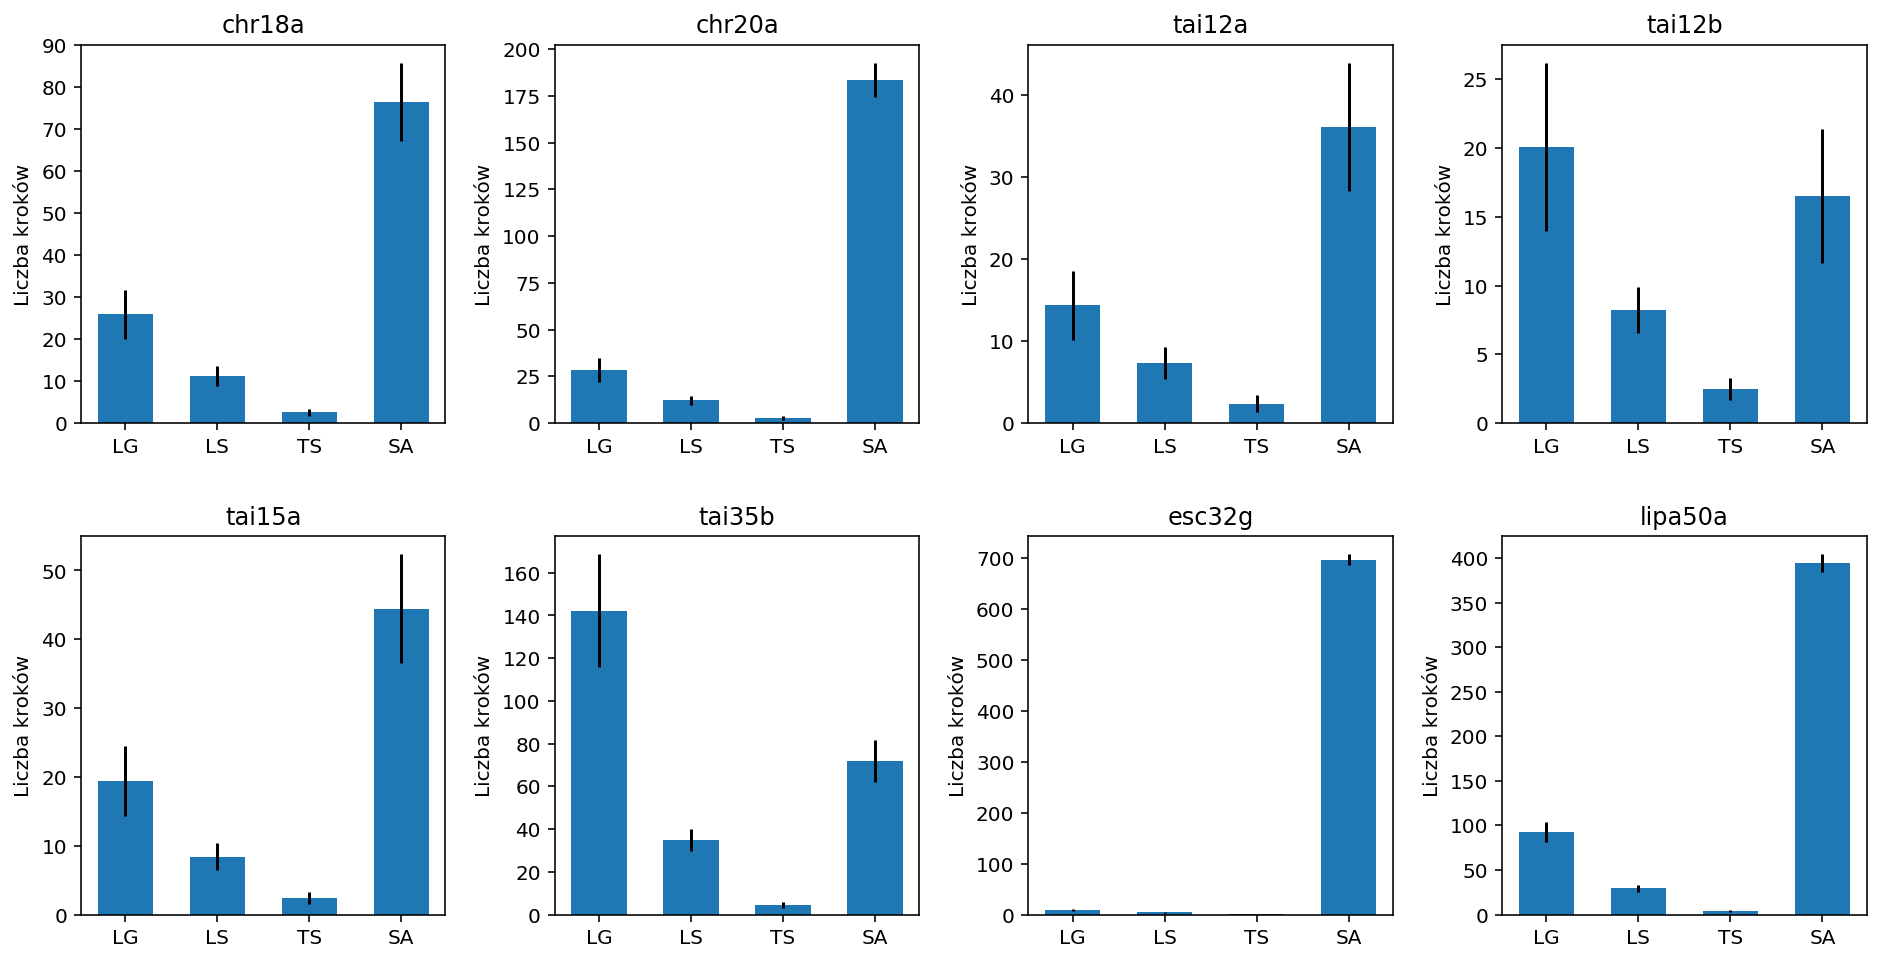

In [20]:
steps_df = get_steps()

fig, all_axes = plt.subplots(nrows=2, ncols=4, dpi=chart_dpi, figsize=(16, 8))
fig.subplots_adjust(hspace=.3, wspace=.3)

for instance, ax in zip(instances, all_axes.flat):
    solvers_df = steps_df[steps_df['instance'] == instance]
    solvers_df = solvers_df[solvers_df['solver'] != 'random-solver']
    solvers_df = solvers_df[solvers_df['solver'] != 'heuristic-solver']

    X = [NAMES[name] for name in solvers_df['solver'].values]
    
    Y_steps = solvers_df['mean_steps'].values
    Y_visited = solvers_df['mean_visited'].values
    Y_std_steps = solvers_df['std_steps'].values
    Y_std_visited = solvers_df['std_visited'].values
    
    indexes = np.arange(len(X))
    bar_width = 0.6
    
    rects1 = ax.bar(indexes, Y_steps, bar_width, yerr=Y_std_steps)
    
    ax.set_title(instance)
    ax.set_ylabel('Liczba kroków')
    ax.set_xticks(indexes)
    ax.set_xticklabels(X)
    ax.tick_params(axis='x')
    
fig.savefig('./steps.png', dpi=chart_dpi)

# Wizyty

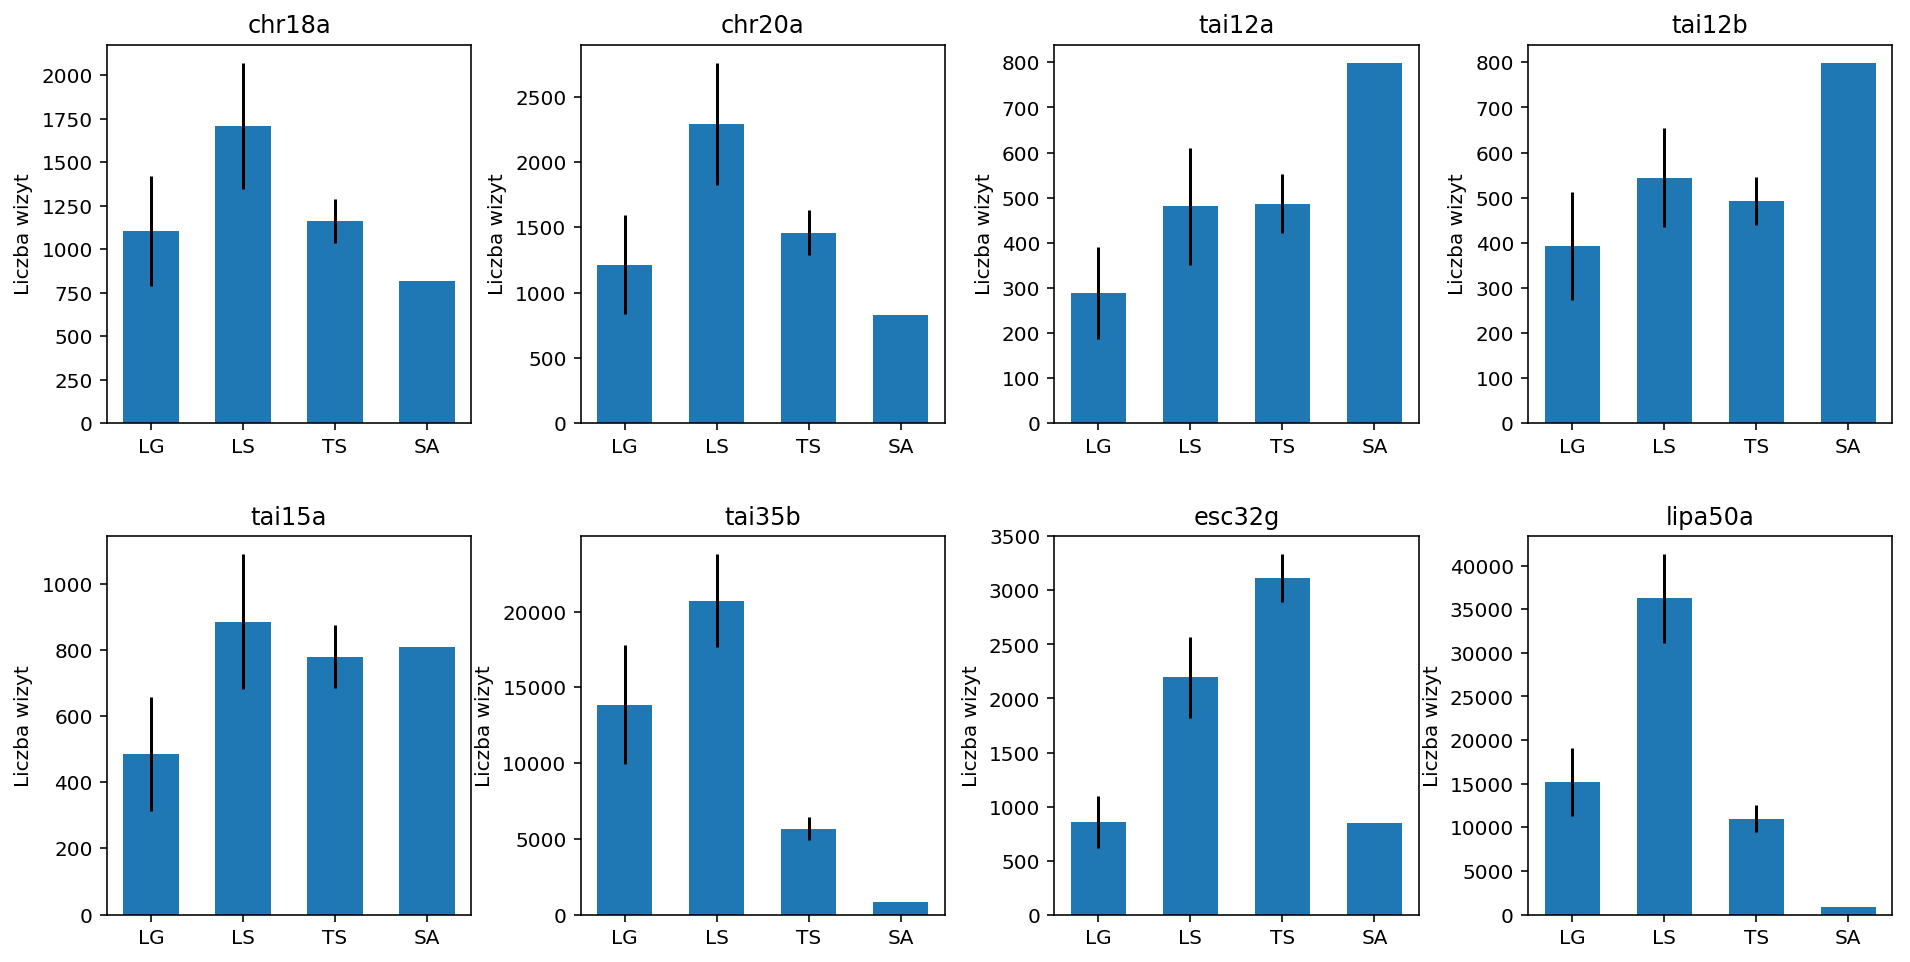

In [21]:
steps_df = get_steps()

fig, all_axes = plt.subplots(nrows=2, ncols=4, dpi=chart_dpi, figsize=(16, 8))
fig.subplots_adjust(hspace=.3, wspace=.3)

for instance, ax in zip(instances, all_axes.flat):
    solvers_df = steps_df[steps_df['instance'] == instance]
    solvers_df = solvers_df[solvers_df['solver'] != 'random-solver']
    solvers_df = solvers_df[solvers_df['solver'] != 'heuristic-solver']

    X = [NAMES[name] for name in solvers_df['solver'].values]
    
    Y_visited = solvers_df['mean_visited'].values
    Y_std_visited = solvers_df['std_visited'].values
    
    indexes = np.arange(len(X))
    bar_width = 0.6
    
    rects2 = ax.bar(indexes, Y_visited, bar_width, yerr=Y_std_visited)
    
    ax.set_title(instance)
    ax.set_ylabel('Liczba wizyt')
    ax.set_xticks(indexes)
    ax.set_xticklabels(X)
    ax.tick_params(axis='x')
    
fig.savefig('./visits.png', dpi=chart_dpi)

# Efektywność algorytmu

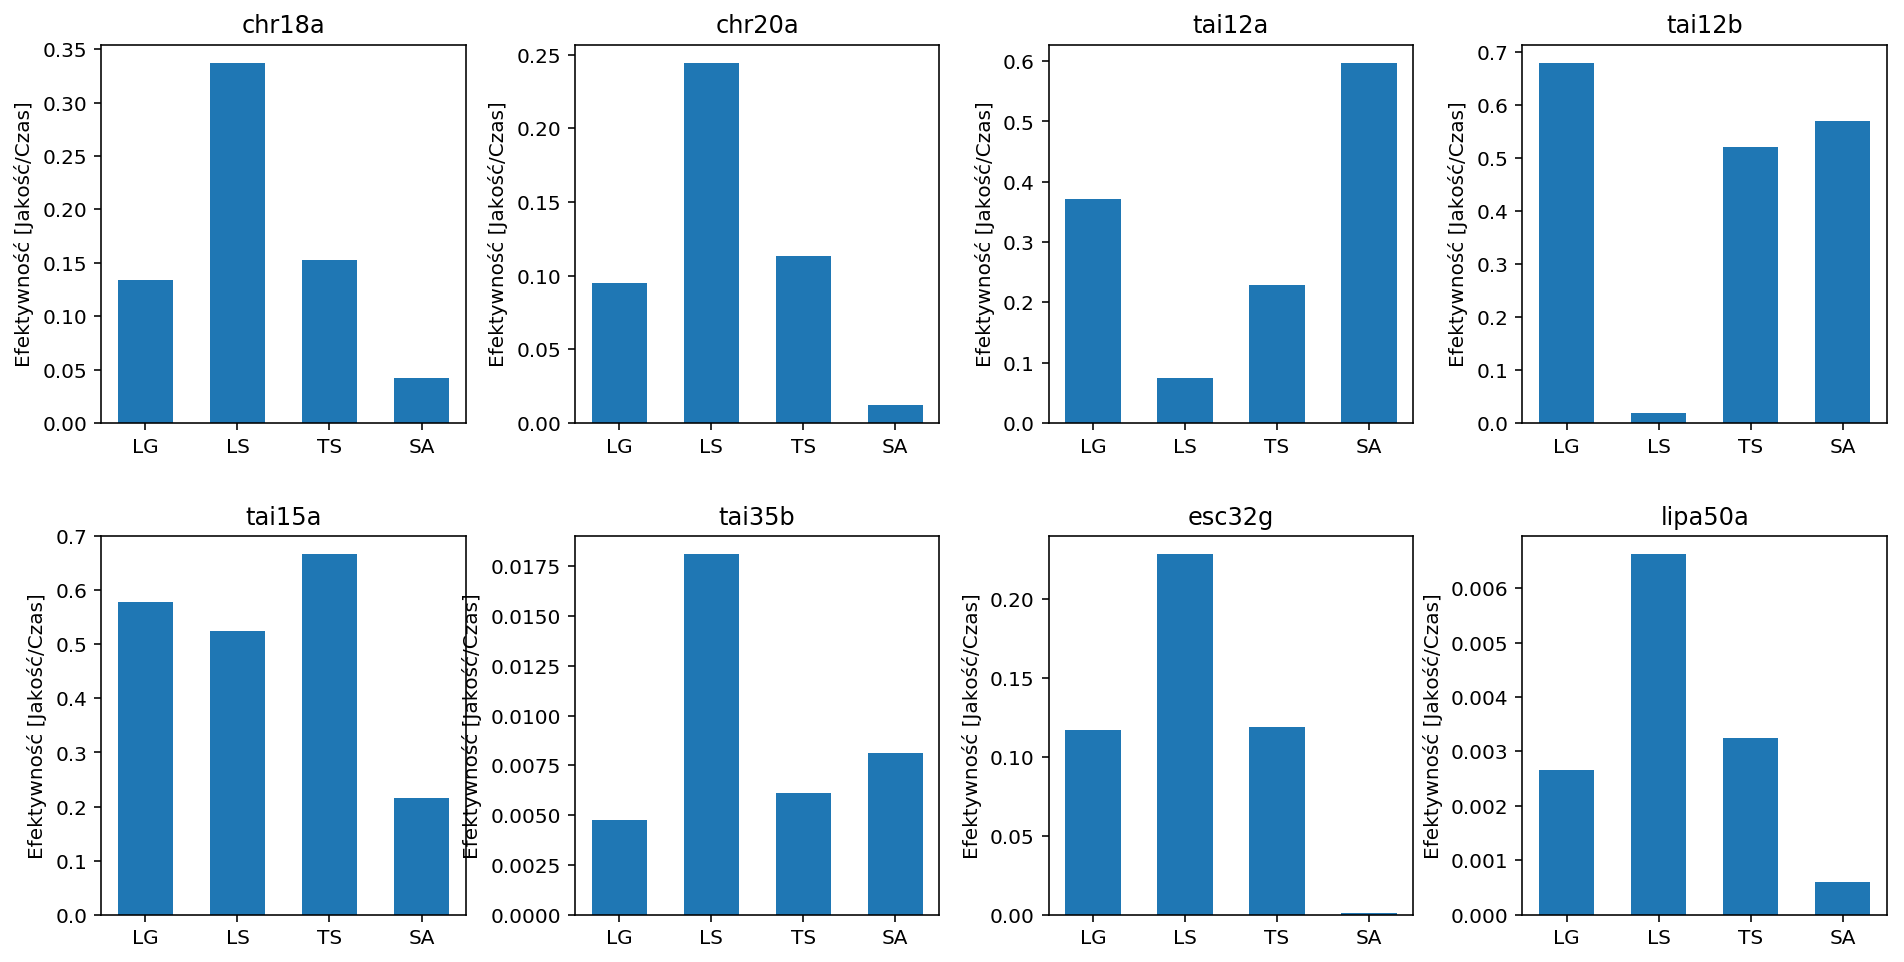

In [22]:
effectiveness_df = get_effectiveness(get_optimal_costs())

fig, all_axes = plt.subplots(nrows=2, ncols=4, dpi=chart_dpi, figsize=(16, 8))
fig.subplots_adjust(hspace=.3, wspace=.3)

for instance, ax in zip(instances, all_axes.flat):
    solvers_df = effectiveness_df[effectiveness_df['instance'] == instance]
    
    X = [NAMES[name] for name in solvers_df['solver'].values]
    Y_effectiveness = solvers_df['mean_effectiveness'].values
    
    indexes = np.arange(len(X))
    bar_width = 0.6
    
    rects2 = ax.bar(indexes, Y_effectiveness, bar_width)
    
    ax.set_title(instance)
    ax.set_ylabel('Efektywność [Jakość/Czas]')
    ax.set_xticks(indexes)
    ax.set_xticklabels(X)
    ax.tick_params(axis='x')
    
fig.savefig('./effectiveness.png', dpi=chart_dpi)